In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import joblib
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
import joblib

In [2]:
df = pd.read_csv('regression_dataset.csv')

In [3]:
# Convert 'OrderDate' to datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

# Set 'OrderDate' as the index
df.set_index('OrderDate', inplace=True)

In [4]:
all_dates = pd.date_range(df.index.min(), df.index.max(), freq='D')

# Step 2: Reindex the DataFrame to include all dates in the full range
df = df.reindex(all_dates)

# Step 3: Fill NaN values
df.ffill(inplace=True)  # Replace 0 with the desired fill value or method

In [5]:
all_dates = pd.date_range(df.index.min(), df.index.max(), freq='D')

missing_date = set(all_dates) - set(df.index.unique())

missing_date

set()

In [6]:
def winsorize(series, lower=0.01, upper=0.99):
    lower_limit = series.quantile(lower)
    upper_limit = series.quantile(upper)
    return series.clip(lower=lower_limit, upper=upper_limit)

for column in df.columns:
    df[column] = winsorize(df[column])

In [7]:
# Define features and targets
features = ['OrderQty', 'UnitPrice', 'UnitPriceDiscount', 'TaxAmt', 'Freight']
targets = ['SalesAmount', 'Average Profit Margin', 'Average_Revenue_Per_User']

# Normalize features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(df[features])

# Normalize targets
scalers_y = {target: StandardScaler() for target in targets}
y_scaled = {target: scalers_y[target].fit_transform(df[[target]]) for target in targets}

In [8]:
# Split data using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
splits = list(tscv.split(X_scaled))

In [9]:
# Define model and hyperparameter grid
param_grid_rf = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 5, 7],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}
param_grid_gb = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7]
}
param_grid_ridge = {'model__alpha': [0.1, 1, 10]}

models = {
    "Random Forest": (RandomForestRegressor(), param_grid_rf),
    "Gradient Boosting": (GradientBoostingRegressor(loss='huber'), param_grid_gb),
    "Ridge Regression": (Ridge(), param_grid_ridge)
}

In [10]:
# # Hyperparameter tuning
# best_model_params = {}  # Dictionary to store best parameters for future use
# best_models = {}

# for target in targets:
#     print(f"Hyperparameter tuning for target: {target}")
#     y_target = y_scaled[target].ravel()

#     for model_name, (model, param_grid) in models.items():
#         print(f"  Tuning {model_name}")
#         pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])
#         grid_search = GridSearchCV(
#             pipeline,
#             param_grid,
#             scoring='neg_mean_squared_error',
#             cv=[(train_index, test_index) for train_index, test_index in splits],
#             n_jobs=-1
#         )
#         grid_search.fit(X_scaled, y_target)
        
#         # Save the best model
#         best_model = grid_search.best_estimator_
#         best_models[f"{target}_{model_name}"] = best_model
        
#         # Save the best parameters
#         best_model_params[f"{target}_{model_name}"] = grid_search.best_params_

#         # Save the model to a file
#         filename = f"best_model_{target}_{model_name}.joblib"
#         joblib.dump(best_model, filename)

#         print(f"    Best parameters for {target} with {model_name}: {grid_search.best_params_}")
#         print(f"    Model saved as {filename}")

# # Save best model parameters to a file for future use
# joblib.dump(best_model_params, "best_model_params.joblib")
# print("\nBest model parameters saved to 'best_model_params.joblib'")


In [11]:
# Define targets and model names
targets = ["SalesAmount", "Average Profit Margin", "Average_Revenue_Per_User"]
model_names = ["Random Forest", "Gradient Boosting", "Ridge Regression"]

# Dictionary to hold the loaded models
best_models = {}

# Load saved models from .joblib files
for target in targets:
    for model_name in model_names:
        # Format the filename to match the saved files
        filename = f"best_model_{target}_{model_name}.joblib"
        try:
            # Load the model
            best_models[f"{target}_{model_name}"] = joblib.load(filename)
            print(f"Loaded model: {filename}")
        except FileNotFoundError:
            print(f"File not found: {filename}")


Loaded model: best_model_SalesAmount_Random Forest.joblib
Loaded model: best_model_SalesAmount_Gradient Boosting.joblib
Loaded model: best_model_SalesAmount_Ridge Regression.joblib
Loaded model: best_model_Average Profit Margin_Random Forest.joblib
Loaded model: best_model_Average Profit Margin_Gradient Boosting.joblib
Loaded model: best_model_Average Profit Margin_Ridge Regression.joblib
Loaded model: best_model_Average_Revenue_Per_User_Random Forest.joblib
Loaded model: best_model_Average_Revenue_Per_User_Gradient Boosting.joblib
Loaded model: best_model_Average_Revenue_Per_User_Ridge Regression.joblib


In [12]:
# # Load saved models into the `best_models` dictionary
# best_models = {}
# for target in targets:
#     for model_name in models.keys():
#         filename = f"best_model_{target}_{model_name}.joblib"
#         best_models[f"{target}_{model_name}"] = joblib.load(filename)
#         print(f"Loaded model: {filename}")

In [13]:
for target in targets:
    y_target_new = y_scaled[target].ravel()  # Update with actual target data
    for model_name in model_names:
        model_key = f"{target}_{model_name}"
        if model_key in best_models:
            model = best_models[model_key]
            model.fit(X_scaled, y_target_new)  # Fit with updated dataset
            print(f"Fitted updated dataset to {model_key}.")

Fitted updated dataset to SalesAmount_Random Forest.
Fitted updated dataset to SalesAmount_Gradient Boosting.
Fitted updated dataset to SalesAmount_Ridge Regression.
Fitted updated dataset to Average Profit Margin_Random Forest.
Fitted updated dataset to Average Profit Margin_Gradient Boosting.
Fitted updated dataset to Average Profit Margin_Ridge Regression.
Fitted updated dataset to Average_Revenue_Per_User_Random Forest.
Fitted updated dataset to Average_Revenue_Per_User_Gradient Boosting.
Fitted updated dataset to Average_Revenue_Per_User_Ridge Regression.


In [14]:
# Evaluation loop
results = {}
for target in targets:
    print(f"\nTraining and evaluating models for target: {target}\n")
    y_target = y_scaled[target].ravel()

    target_results = {"MSE": {}, "MAE": {}, "R2": {}}
    for model_name, (model, _) in models.items():  # Extract only the model from the tuple
        mse_splits, mae_splits, r2_splits = [], [], []
        for train_index, test_index in tscv.split(X_scaled):
            X_train, X_val = X_scaled[train_index], X_scaled[test_index]
            y_train, y_val = y_target[train_index], y_target[test_index]
            
            # Train model
            model.fit(X_train, y_train)
            
            # Predict on validation data (scaled domain)
            y_pred_val = model.predict(X_val)
            
            # Calculate metrics in scaled domain
            mse_splits.append(mean_squared_error(y_val, y_pred_val))
            mae_splits.append(mean_absolute_error(y_val, y_pred_val))
            r2_splits.append(r2_score(y_val, y_pred_val))
        
        # Average results across splits
        target_results["MSE"][model_name] = np.mean(mse_splits)
        target_results["MAE"][model_name] = np.mean(mae_splits)
        target_results["R2"][model_name] = np.mean(r2_splits)
        
        print(f"{model_name} - MSE: {target_results['MSE'][model_name]:.4f}, "
              f"MAE: {target_results['MAE'][model_name]:.4f}, "
              f"R2: {target_results['R2'][model_name]:.4f}")
    
    results[target] = target_results


Training and evaluating models for target: SalesAmount

Random Forest - MSE: 0.0132, MAE: 0.0149, R2: 0.9877
Gradient Boosting - MSE: 0.0222, MAE: 0.0170, R2: 0.9792
Ridge Regression - MSE: 0.0021, MAE: 0.0142, R2: 0.9981

Training and evaluating models for target: Average Profit Margin

Random Forest - MSE: 0.3806, MAE: 0.2549, R2: 0.2162
Gradient Boosting - MSE: 0.3882, MAE: 0.2611, R2: 0.1914
Ridge Regression - MSE: 1.0256, MAE: 0.6740, R2: -1.8977

Training and evaluating models for target: Average_Revenue_Per_User

Random Forest - MSE: 0.1164, MAE: 0.1744, R2: 0.8400
Gradient Boosting - MSE: 0.1002, MAE: 0.1474, R2: 0.8620
Ridge Regression - MSE: 0.5323, MAE: 0.5195, R2: 0.3273



Final Test Results for SalesAmount with Best Model:
MSE: 13773915.6331, MAE: 2531.7796, R2: 0.9999


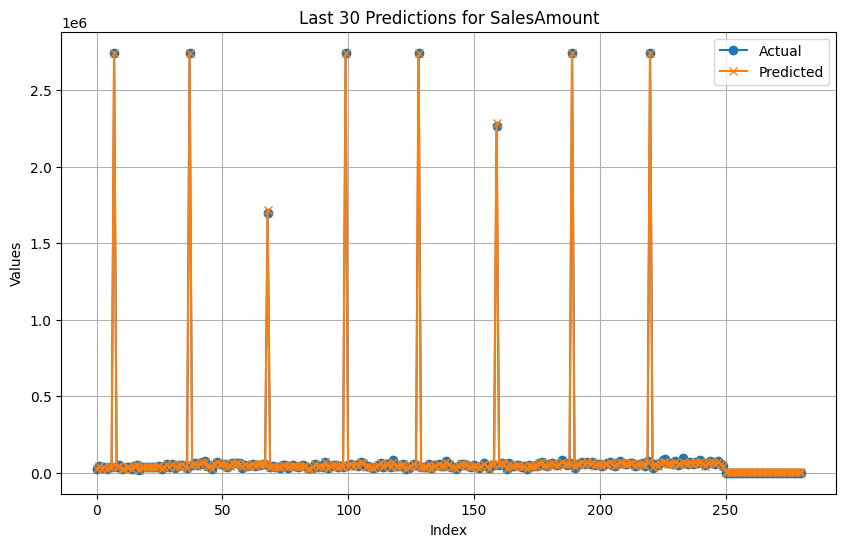


Final Test Results for Average Profit Margin with Best Model:
MSE: 521005.8985, MAE: 484.8340, R2: 0.9828


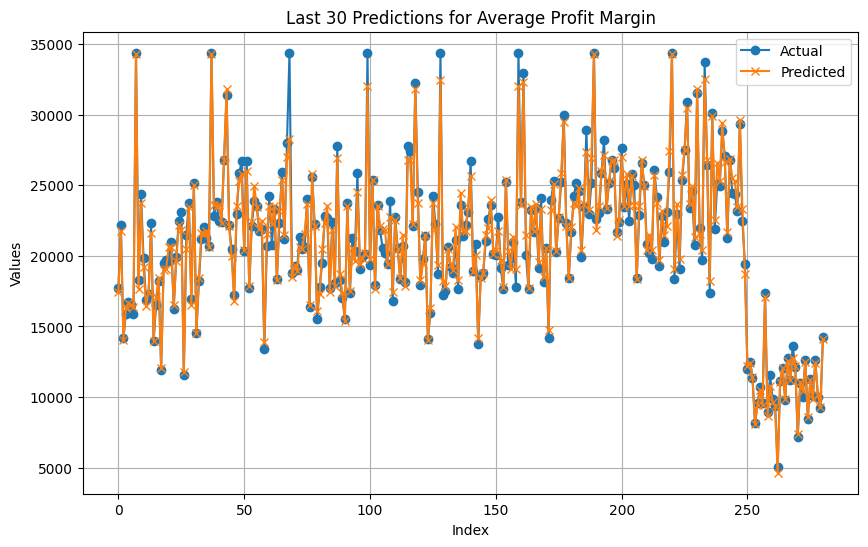


Final Test Results for Average_Revenue_Per_User with Best Model:
MSE: 232232.9326, MAE: 121.4006, R2: 0.9499


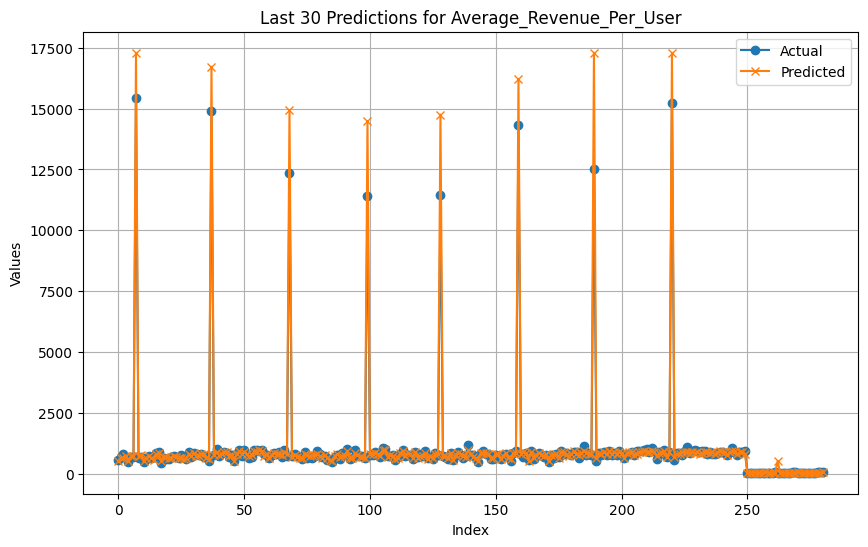

In [15]:
import matplotlib.pyplot as plt

for target in targets:
    # Retrieve the best model for the target
    model = None
    for key, saved_model in best_models.items():
        if key.startswith(target):  # Match the target in the key
            model = saved_model
            break
    
    if model:
        y_test_scaled = y_scaled[target][splits[-1][1]]
        y_pred_test_scaled = model.predict(X_scaled[splits[-1][1]])
        
        # Inverse transform for final predictions
        y_test_original = scalers_y[target].inverse_transform(y_test_scaled.reshape(-1, 1))
        y_pred_test_original = scalers_y[target].inverse_transform(y_pred_test_scaled.reshape(-1, 1))
        
        mse_final = mean_squared_error(y_test_original, y_pred_test_original)
        mae_final = mean_absolute_error(y_test_original, y_pred_test_original)
        r2_final = r2_score(y_test_original, y_pred_test_original)
        
        print(f"\nFinal Test Results for {target} with Best Model:")
        print(f"MSE: {mse_final:.4f}, MAE: {mae_final:.4f}, R2: {r2_final:.4f}")
        
        # Plot Actual vs. Predicted for the last 30 indices
        plt.figure(figsize=(10, 6))
        plt.plot(y_test_original[-365:], label='Actual', marker='o')
        plt.plot(y_pred_test_original[-365:], label='Predicted', marker='x')
        plt.title(f"Last 30 Predictions for {target}")
        plt.xlabel("Index")
        plt.ylabel("Values")
        plt.legend()
        plt.grid()
        plt.show()

In [16]:
start_date = "2013-09-23"
end_date = "2014-06-30"
dates = pd.date_range(start=start_date, end=end_date)
dates.shape

(281,)

In [17]:
import pandas as pd
import numpy as np

# Define the start and end date for labeling
start_date = "2013-09-23"
end_date = "2014-06-30"
dates = pd.date_range(start=start_date, end=end_date)

# Process predictions for each target
results_dfs = {}  # Dictionary to store DataFrames for each target

for target in targets:
    # Retrieve the best model for the target
    model = None
    for key, saved_model in best_models.items():
        if key.startswith(target):  # Match the target in the key
            model = saved_model
            break
    
    if model:
        y_test_scaled = y_scaled[target][splits[-1][1]]
        y_pred_test_scaled = model.predict(X_scaled[splits[-1][1]])
        
        # Inverse transform for final predictions
        y_test_original = scalers_y[target].inverse_transform(y_test_scaled.reshape(-1, 1))
        y_pred_test_original = scalers_y[target].inverse_transform(y_pred_test_scaled.reshape(-1, 1))
        
        # Create a DataFrame with the last 365 values
        df2 = pd.DataFrame({
            "Date": dates[-365:],  # Use the last 365 dates
            "Actual": y_test_original.flatten()[-365:],  # Last 365 actual values
            "Predicted": y_pred_test_original.flatten()[-365:]  # Last 365 predicted values
        })
        
        # Save DataFrame for this target
        results_dfs[target] = df2
        
        # Print sample output
        print(f"\nDataFrame for {target} (last 365 days):")
        # print(df.head())



DataFrame for SalesAmount (last 365 days):

DataFrame for Average Profit Margin (last 365 days):

DataFrame for Average_Revenue_Per_User (last 365 days):


In [18]:
# Initialize a new DataFrame with the Date column
final_df = results_dfs["SalesAmount"][["Date"]].copy()

# Add Actual and Predicted columns for each target
for target, df in results_dfs.items():
    final_df[f"{target}_Actual"] = df["Actual"].values
    final_df[f"{target}_Predicted"] = df["Predicted"].values

# Display the final DataFrame
final_df.head()


,Date,SalesAmount_Actual,SalesAmount_Predicted,Average Profit Margin_Actual,Average Profit Margin_Predicted,Average_Revenue_Per_User_Actual,Average_Revenue_Per_User_Predicted
0,2013-09-23,27583.84,28492.315465,17726.047136,17459.303431,574.663333,537.740172
1,2013-09-24,44684.93,46687.833840,22180.043249,21790.446439,687.460462,665.046723
2,2013-09-25,31332.81,28492.315465,14192.500674,14043.219359,803.405385,669.549734
3,2013-09-26,35940.80,38290.734690,15911.200134,16326.794541,653.469091,728.395730
4,2013-09-27,27813.41,28492.315465,16746.088095,16654.378689,496.668036,537.740172


In [19]:
# # Final prediction and inverse transform
# for target in targets:
#     # Retrieve the best model for the target
#     model = None
#     for key, saved_model in best_models.items():
#         if key.startswith(target):  # Match the target in the key
#             model = saved_model
#             break
    
#     if model:
#         y_test_scaled = y_scaled[target][splits[-1][1]]
#         y_pred_test_scaled = model.predict(X_scaled[splits[-1][1]])
        
#         # Inverse transform for final predictions
#         y_test_original = scalers_y[target].inverse_transform(y_test_scaled.reshape(-1, 1))
#         y_pred_test_original = scalers_y[target].inverse_transform(y_pred_test_scaled.reshape(-1, 1))
        
#         mse_final = mean_squared_error(y_test_original, y_pred_test_original)
#         mae_final = mean_absolute_error(y_test_original, y_pred_test_original)
#         r2_final = r2_score(y_test_original, y_pred_test_original)
        
#         print(f"\nFinal Test Results for {target} with Best Model:")
#         print(f"MSE: {mse_final:.4f}, MAE: {mae_final:.4f}, R2: {r2_final:.4f}")
        
#         # Plot Actual vs. Predicted
#         plt.figure(figsize=(10, 6))
#         plt.scatter(y_test_original, y_pred_test_original, alpha=0.6)
#         plt.plot([y_test_original.min(), y_test_original.max()],
#                  [y_test_original.min(), y_test_original.max()], 'r--', label='Perfect Prediction')
#         plt.title(f"Actual vs. Predicted for {target}")
#         plt.xlabel("Actual Values")
#         plt.ylabel("Predicted Values")
#         plt.legend()
#         plt.show()

In [20]:
# # Extend the index for prediction (e.g., next 7 days)
# future_dates = pd.date_range(start=df.index[-1], periods=31, freq='D')[1:]

# # Prepare initial raw features from the last known features
# last_known_features = pd.DataFrame(
#     scaler_X.inverse_transform(pd.DataFrame(X_scaled[-1].reshape(1, -1), columns=scaler_X.feature_names_in_)),
#     columns=scaler_X.feature_names_in_
# )  # Convert scaled features back to original scale

# # Initialize raw features for updates
# X_future_raw = last_known_features.copy()

# # Initialize scaled features and predictions
# X_future_scaled = [X_scaled[-1]]  # Start with the last known scaled feature set
# future_predictions = {target: [] for target in targets}

# # Define the feature update logic
# def update_features(last_features):
#     """
#     Update features with realistic business logic and trends.
#     Args:
#         last_features (pd.Series): Previous day's features
#     Returns:
#         pd.Series: Updated features
#     """
#     updated_features = last_features.copy()
    
#     # Example business logic for trends or variability:
#     updated_features['OrderQty'] *= (1 + np.random.normal(0.01, 0.005))  # Trend up
#     updated_features['UnitPrice'] *= (1 + np.random.normal(0, 0.002))     # Stable
#     updated_features['UnitPriceDiscount'] = max(0, updated_features['UnitPriceDiscount'] + 
#                                                 np.random.normal(0, 0.02))  # Small fluctuation
#     updated_features['TaxAmt'] = updated_features['UnitPrice'] * 0.1       # Proportional to UnitPrice
#     updated_features['Freight'] *= (1 + np.random.normal(0, 0.003))        # Minor variations
    
#     return updated_features

# # Predict future values dynamically for each target
# for target in targets:
#     # Retrieve the best model for this target
#     model = None
#     for key, saved_model in best_models.items():
#         if key.startswith(target):  # Match the target in the key
#             model = saved_model
#             break
    
#     if not model:
#         raise ValueError(f"No best model found for target: {target}")
    
#     # Loop through each future date
#     for _ in range(len(future_dates)):
#         # Predict using the current scaled features
#         current_prediction = model.predict(X_future_scaled[-1].reshape(1, -1))
#         future_predictions[target].append(current_prediction[0])
        
#         # Update raw features based on the last known raw features
#         next_raw_features = update_features(X_future_raw.iloc[-1])
        
#         # Append the updated raw features
#         X_future_raw = pd.concat(
#             [X_future_raw, pd.DataFrame([next_raw_features], columns=features)],
#             ignore_index=True
#         )
        
#         # Scale the updated features for model input
#         next_scaled_features = scaler_X.transform(next_raw_features.values.reshape(1, -1))[0]
#         X_future_scaled.append(next_scaled_features)

# # Convert predictions back to the original scale
# future_predictions = {
#     target: scalers_y[target].inverse_transform(
#         np.array(future_predictions[target]).reshape(-1, 1)
#     ).flatten()
#     for target in targets
# }

# # Combine predictions into a DataFrame
# future_predictions_df = pd.DataFrame(
#     future_predictions, index=future_dates, columns=targets
# )

# print("Future Predictions:")
# print(future_predictions_df)

In [21]:
# last_known_features['Date'] = [future_dates[0]]
# last_known_features.set_index('Date', inplace=True)

In [22]:
# # Merge by appending future_predictions_df at the end of last_known_features
# merged_df = pd.merge(last_known_features, future_predictions_df, left_index=True, right_index=True, how='outer')
# merged_df = merged_df.reset_index()
# merged_df

In [23]:
# # Create a DataFrame with future predictions
# future_predictions_df.index.name = 'Date'
# future_predictions_df.reset_index(inplace=True)

# # Prepare the original DataFrame with only target columns and Date index
# historical_df = df[targets].copy()
# historical_df.index.name = 'Date'
# historical_df.reset_index(inplace=True)

In [24]:
# historical_df = historical_df.tail(100)

# # Concatenate the historical and future data
# combined_df = pd.concat([historical_df, future_predictions_df], ignore_index=True)

# # Visualize the combined data
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))
# for target in targets:
#     plt.plot(
#         combined_df['Date'],
#         combined_df[target],
#         label=target
#     )

# plt.title('Historical and Future Predictions')
# plt.xlabel('Date')
# plt.ylabel('Values')
# plt.legend()
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [25]:
import pandas as pd
from sqlalchemy import create_engine

# Define your connection string for SQLAlchemy
conn_str = (
    "mssql+pyodbc://@NGUYEN/CompanyX?driver=ODBC+Driver+17+for+SQL+Server"
)

# Create SQLAlchemy engine
engine = create_engine(conn_str)

# Assuming DimCustomer is the DataFrame you want to export
# Specify the target table name
table_name = "Dim_Prediction"

# Export DataFrame to SQL Server
final_df.to_sql(
    name=table_name, 
    con=engine, 
    if_exists='replace',  # Options: 'fail', 'replace', 'append'
    index=False           # Whether to write the DataFrame index
)

print(f"Data exported to table '{table_name}' successfully!")


Data exported to table 'Dim_Prediction' successfully!
